In [1]:
import pandas as pd
from collections import defaultdict, Counter
import array
import scipy.sparse as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# The Dataset


Esse dataset contem avaliações de produtos extraídas da amazon.com, com referências a diversos produtos. Em alguns deles, como livros e dvds, o número de avaliações chega a centenas de milhares. Cada avaliação tem um rating associado com o número de estrelas de 1 a 5. Esse será o nosso balizador para rotolar os dados em sentimentos positivos e negativos. Você pode encontrar mais informação sobre esse banco de dado no link abaixo:

http://www.cs.jhu.edu/~mdredze/datasets/sentiment/

In [2]:
from tqdm import tqdm

dataset_file_unbalance = './dataset/sorted_data/books/unlabeled.review'

def parse_xml(dataset_file): 
    def _active_tag(tag):
        if f'<{tag}>' in line:
            rw[tag] = ''
            return tag
        elif f'</{tag}>' in line:
            return '#end_tag#'
    
    dataset = []
    # columns = ['product_name', 'rating', 'title', 'review_text']
    columns = ['rating', 'review_text']
    active_tag = None
    with open(dataset_file, 'r', encoding='utf-8', errors='ignore') as fp:
        for line in tqdm(fp):
            if '<review>' in line:
                rw = {}
                continue
            elif '</review>' in line:
                dataset.append(rw)
            
            tags = map(_active_tag, columns)
            tag = next((i for i in tags if i is not None), None)
            
            if tag == '#end_tag#':
                rw[active_tag] = rw[active_tag].strip()
                active_tag = None
                continue
            elif tag is not None:
                active_tag = tag
                continue
            
            if active_tag is not None:
                rw[active_tag] += line
            
    return pd.DataFrame(dataset)


df_unbalance = parse_xml(dataset_file_unbalance)

38921221it [03:02, 212709.50it/s]


In [3]:
df_unbalance['rating'] = df_unbalance['rating'].astype('category')

In [4]:
df_unbalance.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973194 entries, 0 to 973193
Data columns (total 2 columns):
rating         973194 non-null category
review_text    973194 non-null object
dtypes: category(1), object(1)
memory usage: 884.8 MB


In [5]:
df_unbalance.head(10)

,rating,review_text
0,5.0,This all-Spanish handbook for parents with new...
1,5.0,McCarthy's writing and portrayal of Lester Bal...
2,2.0,Do you giggle uncontrollably when poking corps...
3,5.0,I was initiated into the world of Cormac McCar...
4,4.0,I cannot speak to the literary points in the n...
5,4.0,There is no denying the strain of Faulkner tha...
6,5.0,I have read sevral of McCarthy's other novels....
7,5.0,This is a gripping novel that probes the bread...
8,1.0,"If you're considering buying the Peter Smith ""..."
9,2.0,What I didn't realise when I ordered this is t...


Text(0.5, 0, 'characters lenght')

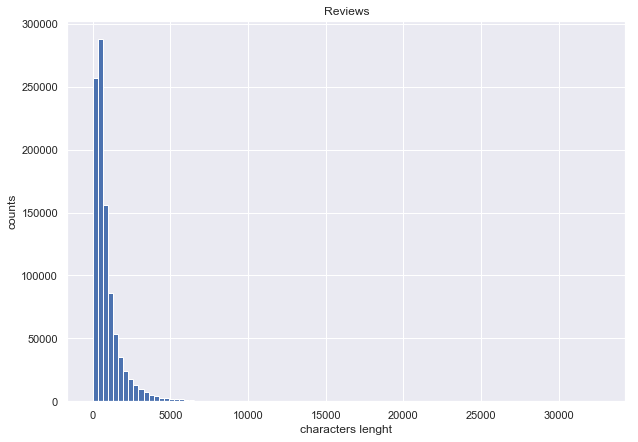

In [6]:
df_unbalance['review_text'].str.len().hist(bins=100, figsize=(10, 7))
plt.title('Reviews')
plt.ylabel('counts')
plt.xlabel('characters lenght')

Text(0.5, 0, 'characters lenght')

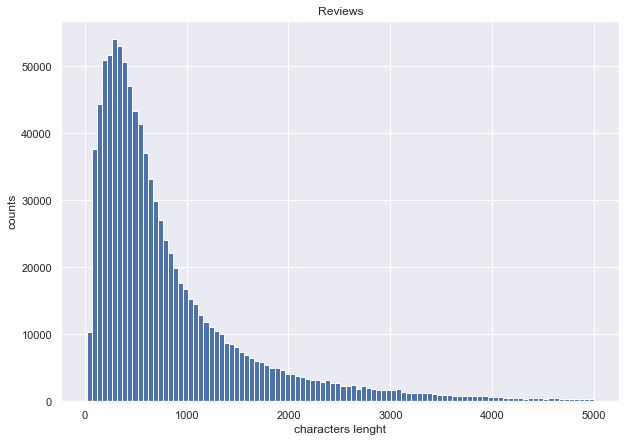

In [7]:
under_5000 = df_unbalance['review_text'].str.len() < 5000
above_20 = df_unbalance['review_text'].str.len() > 20 
df_unbalance[under_5000 & above_20]['review_text'].str.len().hist(bins=100, figsize=(10, 7))
plt.title('Reviews')
plt.ylabel('counts')
plt.xlabel('characters lenght')

In [8]:
df_unbalance = df_unbalance[under_5000 & above_20].copy()

In [9]:
del under_5000
del above_20

In [10]:
df_unbalance.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 962862 entries, 0 to 973193
Data columns (total 2 columns):
rating         962862 non-null category
review_text    962862 non-null object
dtypes: category(1), object(1)
memory usage: 826.1 MB


In [11]:
print('Unbalance reviews: ', df_unbalance.shape[0])

Unbalance reviews:  962862


(0, 700000)

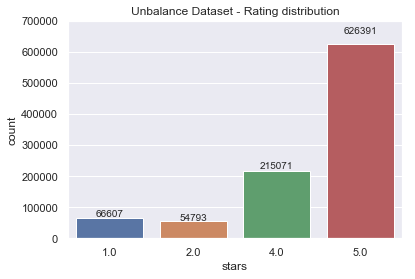

In [12]:
ax = sns.countplot(x='rating', data=df_unbalance)
ax.set_title('Unbalance Dataset - Rating distribution')
ax.set_xlabel('stars')
for rect in ax.containers[0]:
    tw = rect.get_width() / 2.
    tx = rect.get_x() + tw
    height = rect.get_height()
    ty = 1.05 * height
    ax.text(tx, ty, height, ha='center')
    
ax.set_ylim(0, 700000)

# Bag of words

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import regex

In [17]:
stemmer = PorterStemmer()
stop_words = stopwords.words('english')

def tokenizer(text):
    words = regex.findall(r'(?u)\b\w\w+\b', text)
    words = [stemmer.stem(w) for w in words if w not in stop_words]
    return words


In [18]:
df_unbalance['rating'].cat.categories

Index(['1.0', '2.0', '4.0', '5.0'], dtype='object')

In [19]:
limit = df_unbalance[df_unbalance['rating'] == '2.0'].shape[0]
df_balance = pd.concat([
    df_unbalance[df_unbalance['rating'] == '5.0'].sample(limit),
    df_unbalance[df_unbalance['rating'] == '4.0'].sample(limit),
    df_unbalance[df_unbalance['rating'] == '2.0'].sample(limit),
    df_unbalance[df_unbalance['rating'] == '1.0'].sample(limit),
])

In [20]:
df_balance.sort_index(inplace=True)

In [21]:
df_balance['rating'].value_counts()

5.0    54793
4.0    54793
2.0    54793
1.0    54793
Name: rating, dtype: int64

In [22]:
index = df_unbalance.index.difference(df_balance.index)

In [23]:
df_unseen = df_unbalance.loc[index, :].copy()

In [24]:
# reduce memory footprint
del df_unbalance
del index

In [118]:
corpus, labels = df_balance['review_text'], df_balance['rating']

In [119]:
vectorizer = CountVectorizer(tokenizer=tokenizer, min_df=100, max_df=0.9, ngram_range=(1, 3))

In [120]:
X = vectorizer.fit_transform(corpus)

In [121]:
def featurize(x):
    if float(x) > 2.0:
        return 1
    else:
        return 0

In [122]:
y = labels.map(featurize).values

## Bag of words analysis

In [123]:
X[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [124]:
# masks
positive = y == 1
negative = y == 0

In [125]:
positive_count = np.sum(X[positive], axis=0)
positive_count = np.asarray(positive_count).flatten()

In [126]:
negative_count = np.sum(X[negative], axis=0)
negative_count = np.asarray(negative_count).flatten()

In [127]:
features = np.asarray(vectorizer.get_feature_names())

In [ ]:
def plot_top_50_words(positive_count, negative_count, features):
    
    top_50_negative = features[negative_count.argsort()[:-50:-1]].tolist()
    top_50_positive = features[positive_count.argsort()[:-50:-1]].tolist()

    height = positive_count[positive_count.argsort()[:-50:-1].tolist()].tolist()
    ng_height = (negative_count[negative_count.argsort()[:-50:-1].tolist()] * -1).tolist()

    fig = plt.figure(figsize=(15, 15))

    plt.barh(top_50_positive, height, color='b', label='positive')
    plt.barh(top_50_negative, ng_height, color='r', label='negative')
    ax = plt.gca()
    ax.invert_yaxis()
    ax.legend(loc='center right', frameon=False)
    
plot_top_50_words(positive_count, negative_count, features)

In [103]:
features

array(['00', '000', '000 year', ..., 'zombi', 'zone', 'zoo'], dtype='<U26')

In [104]:
ngrams = np.vectorize(lambda x: len(x.split()))
features_ngrams = ngrams(features)
features_ngrams

array([1, 1, 2, ..., 1, 1, 1])

In [105]:
bigrams = features_ngrams == 2
trigrams = features_ngrams == 3

In [107]:
positive_count_bigrams = positive_count[bigrams]
negative_count_bigrams = negative_count[bigrams]
positive_count_trigrams = positive_count[trigrams]
negative_count_trigrams = negative_count[trigrams]

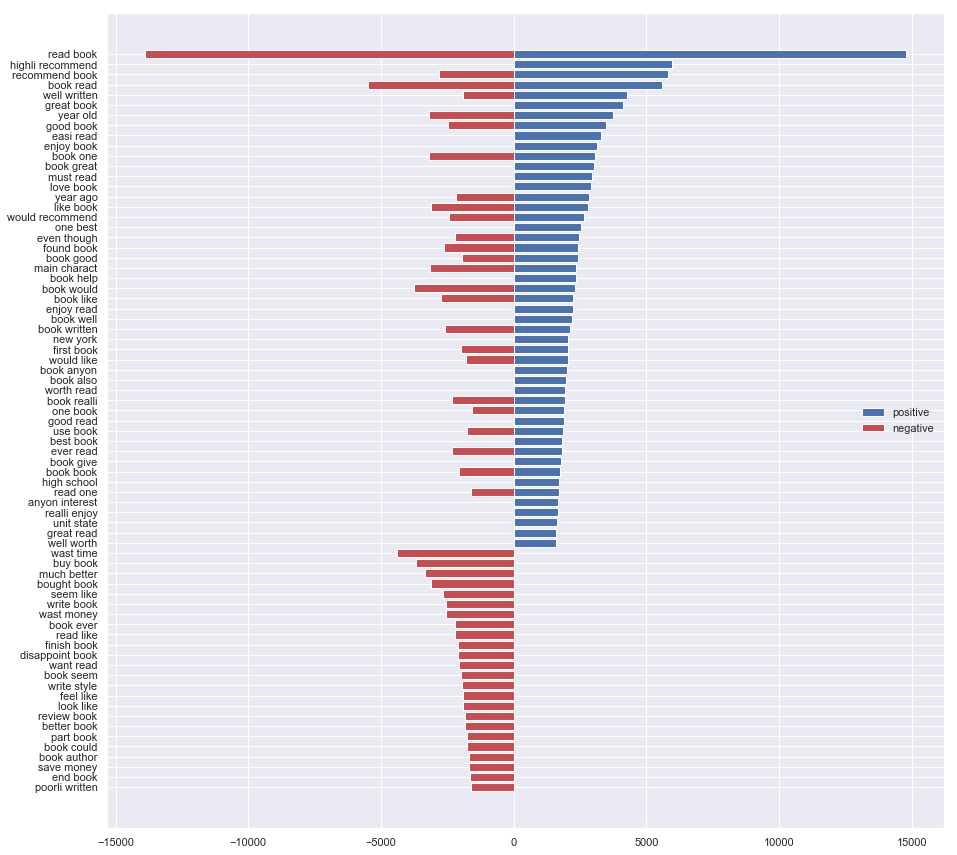

In [111]:
plot_top_50_words(positive_count_bigrams, negative_count_bigrams, features[bigrams])

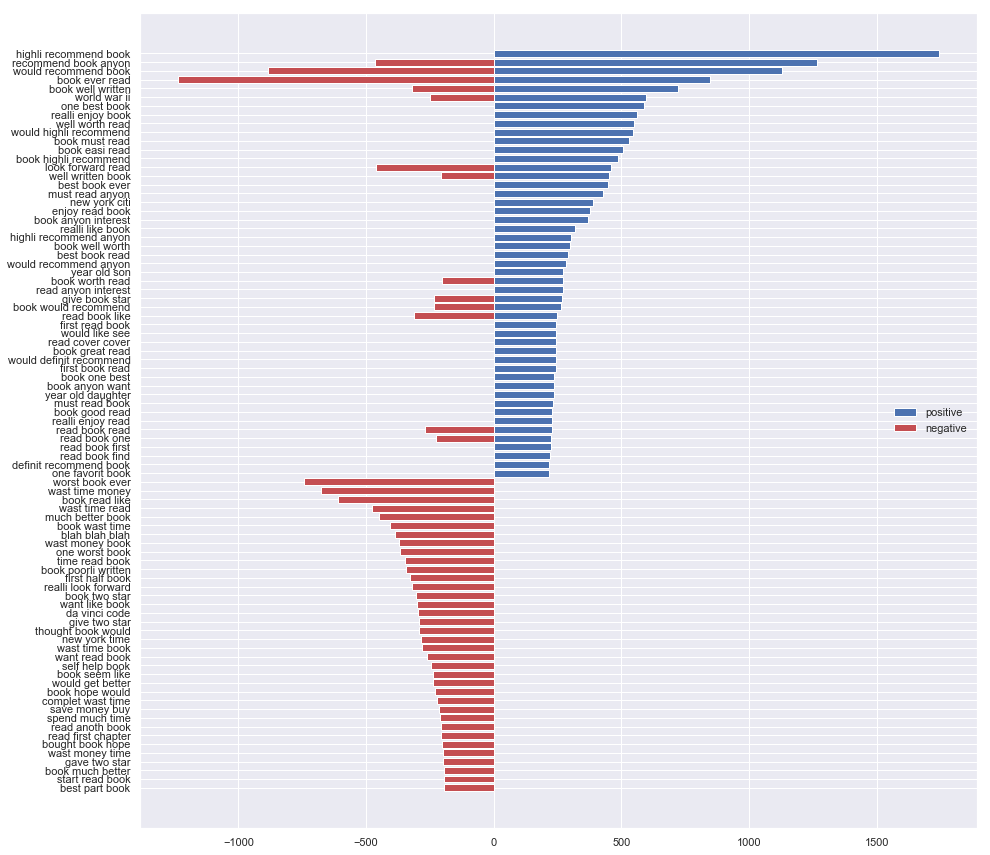

In [112]:
plot_top_50_words(positive_count_trigrams, negative_count_trigrams, features[trigrams])

## TFIDF Analysis

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)

IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

In [113]:
from sklearn.feature_extraction.text import TfidfTransformer

In [114]:
X_tfidf = TfidfTransformer().fit_transform(X)

In [115]:
text1 = "I've read the book but I did'n like it"
text2 = "I've read the book and I like it a lot"

analyser = vectorizer.build_analyzer()
    
doc1 = analyser(text1)
doc2 = analyser(text2)

corpus = [doc1, doc2]
corpus

[['read', 'book', 'like', 'read book', 'book like', 'read book like'],
 ['read',
  'book',
  'like',
  'lot',
  'read book',
  'book like',
  'like lot',
  'read book like',
  'book like lot']]

# Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Split Train and Test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def featurize(rating):
    if rating > 2.0:
        return 1 # positive
    else:
        return 0 # negative

In [ ]:
y = y.apply(featurize)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Dummy Classifier

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

In [ ]:
dummy_clf.score(X_test, y_test)

# Model selection

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

In [ ]:
clf = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
y_pred = clf.predict(X_test)

# Metrics

In [ ]:
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels

In [ ]:
def plot_confusion(y_test, y_pred, title, classes=np.asarray(['negative', 'positive'])):
    cm = metrics.confusion_matrix(y_test, y_pred)
    labels = classes[unique_labels(y_test, y_pred)]
    plt.figure(figsize=(7, 7))
    ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
   

In [ ]:
title = f'Logistic Regression accuracity scores: {metrics.accuracy_score(y_test, y_pred):.2f}'
plot_confusion(y_test, y_pred, title)

# Model Selection

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

In [ ]:
multinomial_nb = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

In [ ]:
sgd_classifier = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                           max_iter=5, tol=None)),
])

In [ ]:
clfs = [
    ('logistic regression', LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000)),
    ('multinomial naive bayes', multinomial_nb),
    ('SGD classifier', sgd_classifier),    
]

In [ ]:
for title, clf in clfs:
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(title, ': ', score)

# Tunning Hyperparams

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {'alpha': [0.01, 0.5, 1], 'fit_prior': [True, False]}

In [ ]:
clf = GridSearchCV(MultinomialNB(), param_grid=params, cv=5)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.best_params_